# Scientific Data Analysis
Jasper Wink, 14616513 \
Dennis van der Werff, ...

# Imports

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller


In [69]:
# Read data
cn = pd.read_csv("data/cryptonews.csv")
bp = pd.read_csv("data/btc.csv")

Group the data for each month. \
Determine the amount of articles for each month. \
Determine the mean opening bitcoin price for each month.

In [70]:
# Convert the date to the datetime format
cn['date'] = pd.to_datetime(cn['date'], format='%Y-%m-%d %H:%M:%S')
bp['date'] = pd.to_datetime(bp['Date'], format='%Y-%m-%d')

# Only keep the year and months of the date
cn['year_month'] = cn['date'].dt.to_period('M')
bp['year_month'] = bp['date'].dt.to_period('M')

# Group data by the months
cn_monthly_count = cn.groupby('year_month').size().reset_index(name='Count')
bp_monthly_mean = bp.groupby('year_month')['Open'].mean().reset_index(name='Open_mean')




# Spearman correlation

In [71]:
# https://en.wikipedia.org/wiki/Spearman's_rank_correlation_coefficient
def spearman_correlation(rank1, rank2):
    n = len(rank1)

    sum_d_squared = sum([(rank1[i] - rank2[i])**2 for i in range(n)])
    correlation = 1 - ((6 * sum_d_squared) / (n * (n**2 - 1)))
    return correlation


# Calculate ranks
cn_rank = list(cn_monthly_count['Count'].rank())
bp_rank = list(bp_monthly_mean['Open_mean'].rank())

correlation = spearman_correlation(cn_rank, bp_rank)
print(f"Spearman Correlation: {correlation:.3f}")


Spearman Correlation: -0.243


# Plot of the normalized data

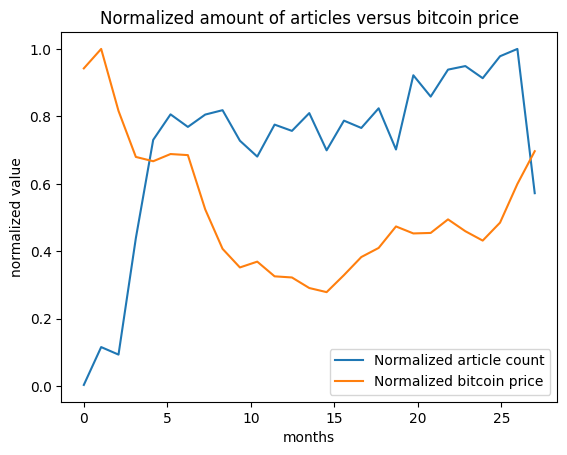

In [72]:
# Normalize the data
cn_count_list = list(cn_monthly_count['Count'])
normalized_count = [count / max(cn_count_list) for count in cn_count_list]

bp_mean_list = list(bp_monthly_mean['Open_mean'])
normalized_mean = [mean / max(bp_mean_list) for mean in bp_mean_list]

# Plot the data
x = np.linspace(0, len(normalized_mean), len(normalized_mean))
plt.plot(x, normalized_count, label='Normalized article count')
plt.plot(x, normalized_mean, label='Normalized bitcoin price')
plt.title('Normalized amount of articles versus bitcoin price')
plt.xlabel('months')
plt.ylabel('normalized value')
plt.legend()
plt.show()

# Sentiment analysis

/tmp/ipykernel_41091/1229576149.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


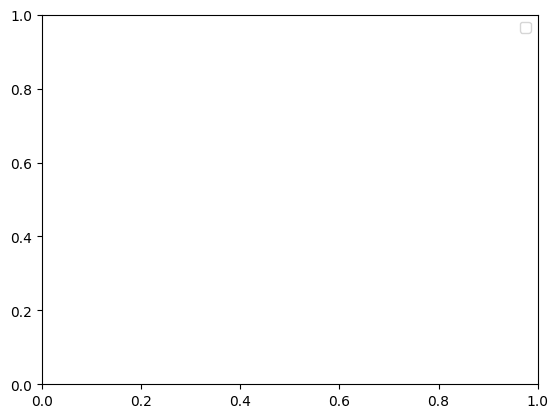

In [74]:


# Plot the data
x = np.linspace(0, 1)

plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.show()

# Stationary test

Using the Augmented Dickey-Fuller (ADF) test if the current datasets are satationary.

In [77]:
first_diff = cn_monthly_count['Count'].diff()[1:]

ad_fuller_result = adfuller(first_diff)
print(f'p-value: {ad_fuller_result[1]} (Count)')

ad_fuller_result = adfuller(bp_monthly_mean['Open_mean'].diff()[1:])
print(f'p-value: {ad_fuller_result[1]} (Open)')


p-value: 0.45238888060839716 (Count)
p-value: 0.044416805059388526 (Open)
